In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
vero = pd.read_csv('verodata.csv', index_col=0)
records = pd.read_csv('records_processed.csv', index_col=0)

vero['Kunta'] = vero.Verotuskunta.str[:3].str.strip().fillna(vero.Verotuskunta).astype(int)
pienet = vero.Kunta.value_counts().index[vero.Kunta.value_counts() < 7446].values
vero.loc[vero.Kunta.isin(pienet),'Kunta'] = 0

vero['Oy'] = (vero['Verovelvollisen nimi'].str.contains(' Ab') | \
vero['Verovelvollisen nimi'].str.contains(' Oy')).astype(int)
vero.drop(['Verovelvollisen nimi', 'Verotuskunta'], 1, inplace=True)

records = pd.get_dummies(records, columns=['typeOfRegistration'])
records.drop(['entryCodes', 'registrationDate'], 1, inplace=True)
records['Verovuosi'] = records.index.str[:4].astype(int)
records = records.groupby(['businessId', 'Verovuosi']).sum().reset_index()

vero = pd.merge(vero, records, how='left', left_on=['Y-tunnus', 'Verovuosi'],
         right_on=['businessId', 'Verovuosi']).fillna(0).drop('businessId', 1)


vero['Muutokset'] = vero.iloc[:,8:-11].sum(1)
vero['Tyypit'] = vero.iloc[:,-12:-1].sum(1)

C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Predictive modelling

In [74]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import featuretools as ft
from sklearn.metrics import log_loss

In [75]:
X = vero[['Y-tunnus', 'Verovuosi', 'Verotettava tulo', 'Maksuunpannut verot yhteensä',
       'Ennakot yhteensä', 'Veronpalautus', 'Jäännösvero', 'Oy', 'Muutokset', 'Tyypit']]
X.columns = ['yTunnus', 'Verovuosi', 'Verotettava tulo', 'Maksuunpannut verot yhteensä',
       'Ennakot yhteensä', 'Veronpalautus', 'Jäännösvero', 'Oy', 'Muutokset', 'Tyypit']
X.to_hdf('pred_X.h5', key='X', complib='blosc', format='table', data_columns=['yTunnus'])

In [76]:
features = X.columns[1:]
for col in features:
    for col2 in features:
        X[col+'*'+col2] = (X[col2] * X[col])
for col in features:
    for col2 in features:
        X[col+'/'+col2] = (X[col2] / X[col])
        
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [77]:
X = X[X.Verovuosi<2018]
X_agg = X.groupby('Y-tunnus').agg(['mean', 'last'])
X_agg.columns = [' '.join(col) for col in X_agg.columns]

KeyError: 'Y-tunnus'

In [ ]:
protests = pd.read_csv('protestit2.csv', index_col=0).set_index('0')
ind = protests[(pd.to_datetime(protests['3']) >= '2019-11-01')].index

pd.Series(ind.unique(), name='yTunnus')\
    .to_hdf('y.h5', key='x', complib='blosc', format='table', data_columns=['yTunnus'])

ind = protests[(pd.to_datetime(protests['3']) >= '2018-11-01')&\
               (pd.to_datetime(protests['3']) < '2019-11-01')].index
X_agg = X_agg[X_agg['Verovuosi last'] == 2017]
y = (X_agg.index.isin(ind)).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_agg, y, stratify=y, random_state=42)
kfold = StratifiedKFold()

#### Logistic regression with set of engineered features

In [58]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.01)
log_pipe = Pipeline([('sclr', StandardScaler()), ('clf', logreg)])
log_pipe.fit(X_train, y_train)
print('Acc on train data: ', log_pipe.score(X_train, y_train))
print('Acc on test data: ', log_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, log_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, log_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9705071334372377
Acc on test data:  0.9706629900491548
Training benchmark:  0.9708588098948967 
Test benchmark:  0.9708588098948967
Log loss on train:  0.11552986197110793
Log loss on test:  0.11546885662733802
Training benchmark:  0.13174406857663049 
Test benchmark:  0.13175807979994478


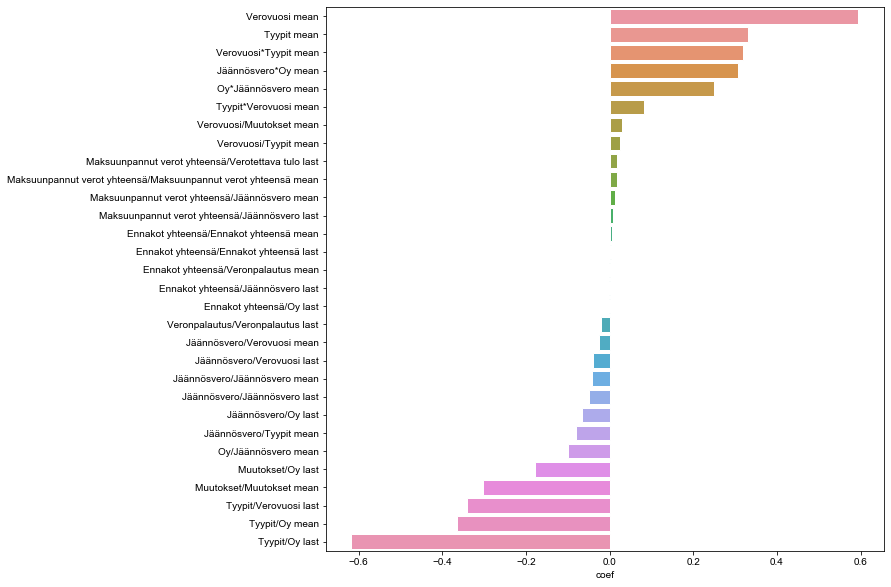

In [59]:
coef = log_pipe['clf'].coef_[0]
coef = pd.DataFrame(coef[coef != 0], index=X_agg.columns[coef != 0], columns=['coef'])
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef.sort_values('coef', ascending=False))

In [71]:
def plot_cols(col1, col2, ylim=None, xlim=None):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.regplot(x=col1, y=col2, data=X_test[y_test == 0],
                fit_reg=False, ax=ax, color='green')
    sns.regplot(x=col1, y=col2, data=X_test[y_test == 1],
                fit_reg=False, ax=ax, color='red')
    ax.legend(labels=['No protests', 'Protests'])
    if ylim is not None:
        sns.plt.ylim(ylim)
    if xlim is not None:
        sns.plt.xlim(xlim)
    return None

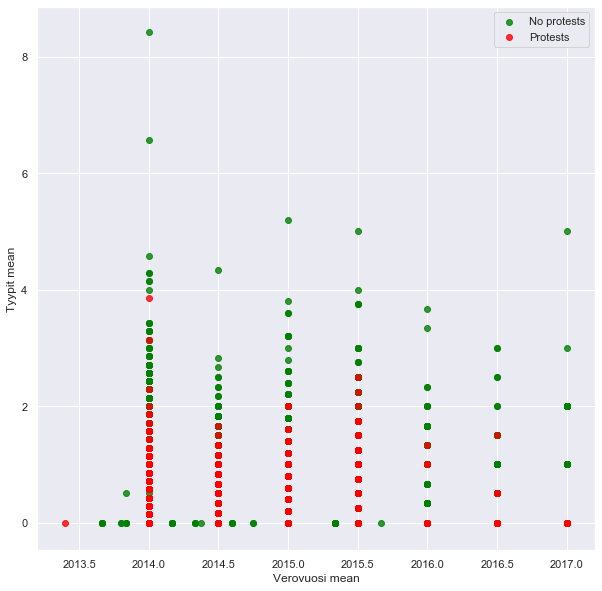

In [112]:
plot_cols('Verovuosi mean', 'Tyypit mean')

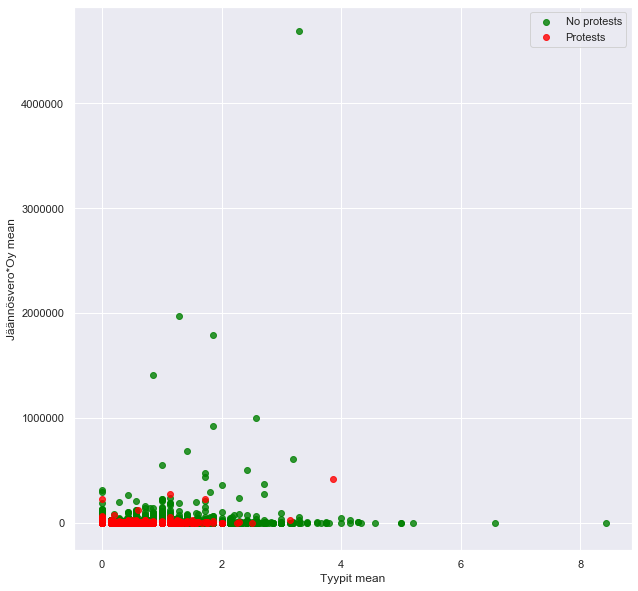

In [113]:
plot_cols('Tyypit mean','Jäännösvero*Oy mean')

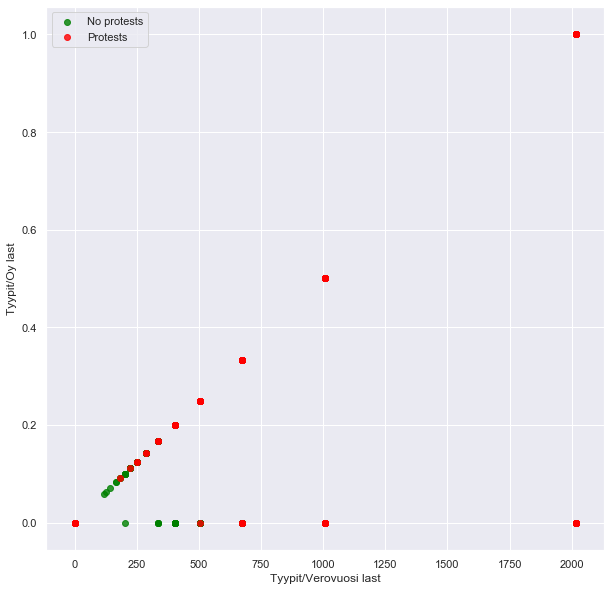

In [114]:
plot_cols('Tyypit/Verovuosi last', 'Tyypit/Oy last')

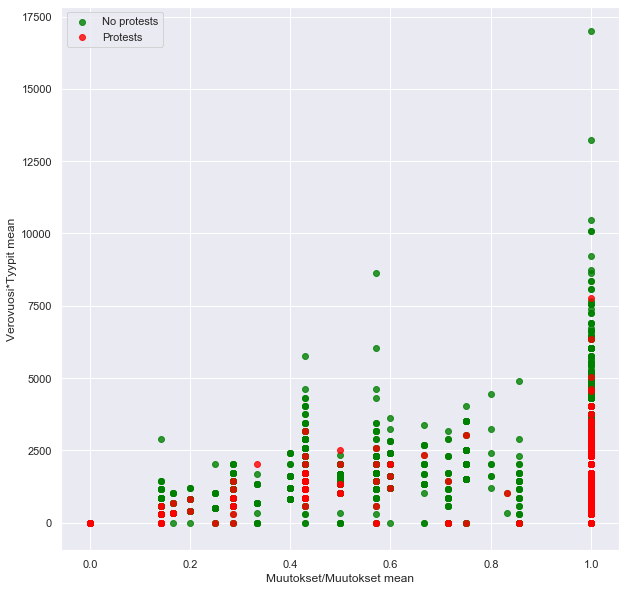

In [116]:
plot_cols('Muutokset/Muutokset mean','Verovuosi*Tyypit mean')

In [117]:
params={
    'subsample': 0.9,
    'validation_fraction': 0.1, 
    'n_iter_no_change': 10,
    'learning_rate': 0.08,
    'n_estimators': 10000,
    'max_depth': 4
}
gbc = GradientBoostingClassifier(**params)
gb_pipe = Pipeline([('sclr', StandardScaler()), ('clf', gbc)])
gb_pipe.fit(X_train, y_train)
print('Acc on train data: ', gb_pipe.score(X_train, y_train))
print('Acc on test data: ', gb_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, gb_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, gb_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9712864164968229
Acc on test data:  0.9705670782879751
Training benchmark:  0.9708588098948967 
Test benchmark:  0.9708588098948967
Log loss on train:  0.10156388225849912
Log loss on test:  0.10479230651909452
Training benchmark:  0.13174406857663049 
Test benchmark:  0.13175807979994478


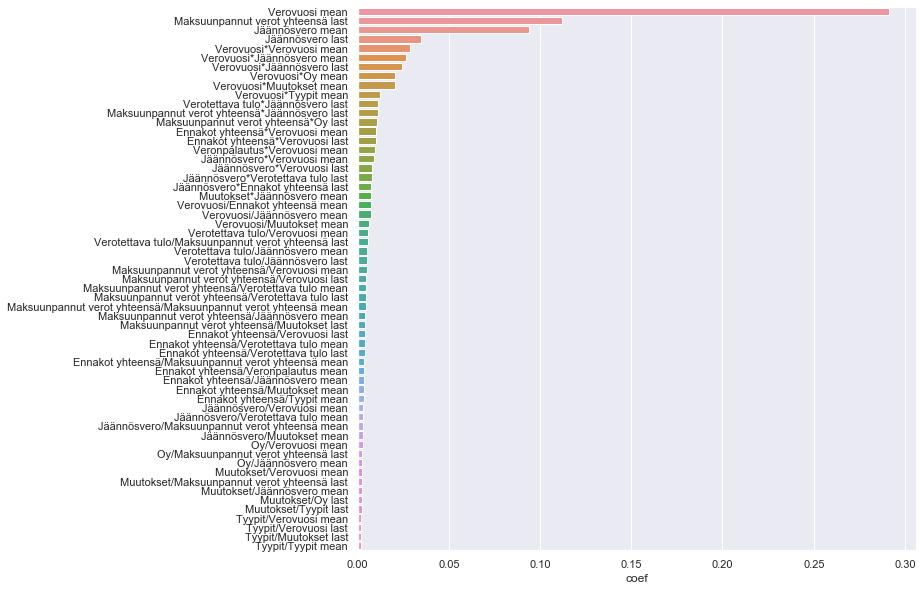

In [118]:
coef = gb_pipe['clf'].feature_importances_
coef = pd.DataFrame(coef[coef > 0.002], index=X_agg.columns[coef > 0.002], columns=['coef'])
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef.sort_values('coef', ascending=False))


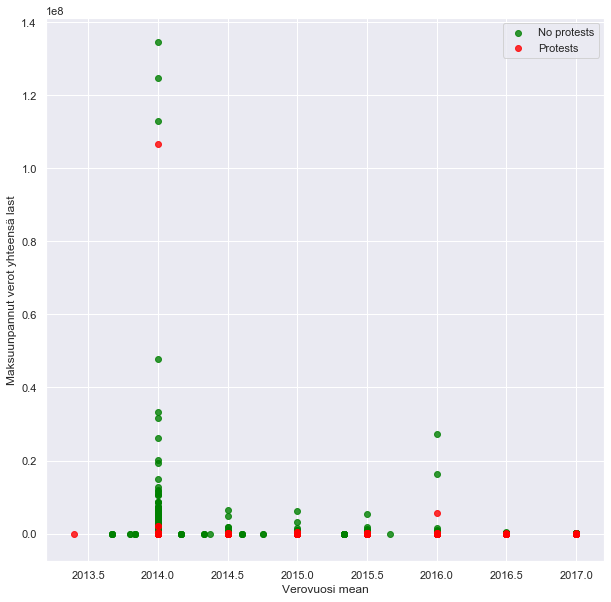

In [126]:
plot_cols('Verovuosi mean','Maksuunpannut verot yhteensä last')

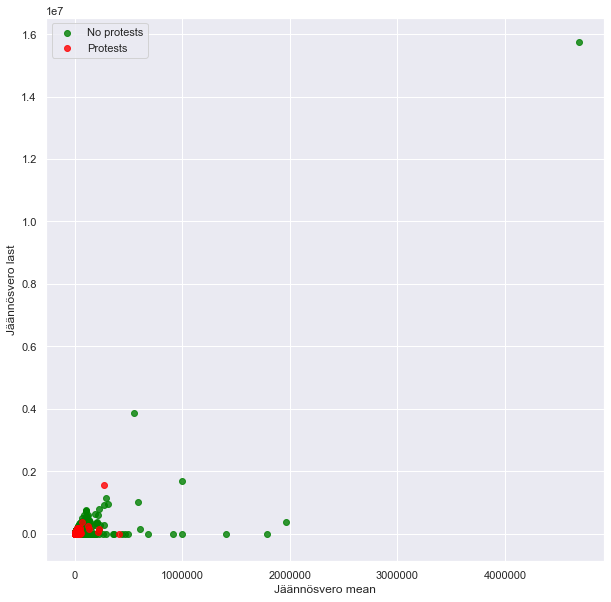

In [127]:
plot_cols('Jäännösvero mean','Jäännösvero last', ylim=(0,.6), xlim=(0, 2000000))

### Deep learning model

In [119]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [120]:
n_cols = X_agg.shape[1]
input_shape = (n_cols,)

def create_model():
    # Specify the model
    model = Sequential()
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/2), input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/4), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
    return model

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nnc = KerasClassifier(build_fn=create_model, epochs=160, verbose=1)

In [121]:
nn_pipe = Pipeline([('sclr', MinMaxScaler()), ('clf', nnc)])
history = nn_pipe.fit(X_train, y_train, clf__validation_split=0.1,
                      clf__callbacks=[early_stopping_monitor])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 225207 samples, validate on 25023 samples
Epoch 1/160





225207/225207 [==============================] - 40s 176us/step - loss: 0.1216 - val_loss: 0.1087
Epoch 2/160
225207/225207 [==============================] - 42s 185us/step - loss: 0.1156 - val_loss: 0.1067
Epoch 3/160
225207/225207 [==============================] - 41s 182us/step - loss: 0.1141 - val_loss: 0.1046
Epoch 4/160
225207/225207 [==============================] - 41s 184us/step - loss: 0.1130 - val_loss: 0.1054
Epoch 5/160
225207/225207 [==============================] - 41s 183us/step - loss: 0.1125 - val_loss: 0.1020
Epoch 6/160
225207/225207 [==============================] - 40s 175us/step - loss: 0.1117 - val_loss: 0.1029
Epoch 7/160
225207/225207 [==============================] - 41s 183us/step - loss: 0.1114 - val_loss: 0.1076
Epoch 8/160
225207/225207 [==============================] - 38s 169us/s

In [122]:
print('Log loss on train: ', log_loss(y_train, nn_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, nn_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

250230/250230 [==============================] - 9s 36us/step
Log loss on train:  0.10849572432081643
83410/83410 [==============================] - 2s 29us/step
Log loss on test:  0.1096625409086028
Training benchmark:  0.13174406857663049 
Test benchmark:  0.13175807979994478


In [123]:
import pickle
pickle.dump(log_pipe, open('logit.pkl', 'wb'))
pickle.dump(gb_pipe, open('gb.pkl', 'wb'))
nn_pipe['clf'].model.save('nn.h5')

### Ensembling

In [125]:
print('Log loss on train: ', log_loss(y_train, ((gb_pipe.predict_proba(X_train)\
 + nn_pipe.predict_proba(X_train))/2)))

print('Log loss on test: ', log_loss(y_test, ((gb_pipe.predict_proba(X_test)\
 + nn_pipe.predict_proba(X_test))/2)))

250230/250230 [==============================] - 6s 25us/step
Log loss on train:  0.1026487703423146
83410/83410 [==============================] - 2s 25us/step
Log loss on test:  0.1049722959195518


In [132]:
pd.DataFrame(gb_pipe.predict_proba(X_test.iloc[:3,:])[:,1], index=X_test.index[:3])

,0
Y-tunnus,
2654635-1,0.013485
1077434-1,0.006242
2471021-8,0.014134
